### Naive predictions and Random Forest Baseline

For a baseline model, this notebook implements:
- Naive method of forecasting where it uses the most recent newarrival available
- RandomForest method, simply considering the data basically as cross-sectional data.

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('../../data/data.csv', engine='pyarrow').drop_duplicates(subset=['Id','year']).drop(['Country_o','Country_d','iso_d','iso_o', ''], axis=1)

#### Preprocessing

In [2]:
# filter out missing data
data = data[data.year < 2022]

# there are some countries that are contiguous but aren't marked as so. this corrects that
data[data.Id.isin(['SSDETH', 'ETHSSD','SSDUGA','UGASSD','CODUGA','UGACOD','SSNSSD','SSDSSN','CODCOG','COGCOD'])].contig = 1

# all observations must have at least one value greater than c
c = 100
#data = data.groupby('Id', as_index=False).filter(lambda x: x['newarrival'].max() > c)

data['year'] = pd.to_datetime(data['year'], format='%Y')
data = data.set_index(['year', 'Id'])
data.index.levels[1].freq = "Y"
#data = data['y']
data = data.sort_index()

/var/folders/hs/1r2tlf751_l1nl8n9l2_wtpw0000gn/T/ipykernel_28760/720787505.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data.Id.isin(['SSDETH', 'ETHSSD','SSDUGA','UGASSD','CODUGA','UGACOD','SSNSSD','SSDSSN','CODCOG','COGCOD'])].contig = 1


Specify train and test sets:

In [3]:
end_train = '2016-01-01'
end_val = '2016-01-01'

data_train = data.loc[:end_train, :].copy()
# data_val   = data.loc[end_train:end_val, :].copy()
data_test  = data.loc[end_val:, :].copy()

#### Naive method- Baseline approach

In [113]:
def filter_multi(df,col,val):
    col_index = pd.Series(df.index.names)[(pd.Series(df.index.names) == col)].index.tolist()[0]
    if val is type(str):
        return np.in1d(df.index.get_level_values(col_index), [val])
    else:
        return pd.Series(data.index.get_level_values(col_index)).isin(val).values
    
import operator
def filter_multi_date(df,col,val, relate):
    ops = {'>': operator.gt,
        '<': operator.lt,
        '>=': operator.ge,
        '<=': operator.le,
        '==': operator.eq}
    col_index = pd.Series(df.index.names)[(pd.Series(df.index.names) == col)].index.tolist()[0]
    return ops[relate](df.index.get_level_values(col_index),  pd.to_datetime(val))

In [5]:
# naive prediction
def naive_prediction(series, h):
    last_val = series.iloc[-1]
    pred =  np.repeat(last_val, h)
    return pred

def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

# rolling window rmse
def rolling_rmse(series, window_len, h):
    series_len = len(series)
    n_of_forecasts = (series_len - (window_len + h) + 1)

    if n_of_forecasts < 1:
        raise ValueError
    
    errors = np.array([])
    errors.shape = (0, 3)

    for i in range(n_of_forecasts):
        window = series.iloc[i:(i + window_len)]
        forecast = naive_prediction(window, h)
        actual = series[(i + window_len):(i + window_len + h)].values
        
        rmse_error = ((forecast - actual)**2)**.5
        errors = np.vstack([errors, rmse_error])

    return pd.DataFrame(errors, columns = np.array([*range(3)])+1).melt(var_name='horizon',value_name='naive')

# rolling window predictions
def rolling_prediction(series, window_len, h):
    series_len = len(series)
    
    n_of_forecasts = (series_len - (window_len + h) + 1)
    
    if n_of_forecasts < 1:
        raise ValueError
    
    errors = np.array([])
    errors.shape = (0, 3)

    actual = []
    forecast = []

    for i in range(n_of_forecasts):
        window = series.iloc[i:(i + window_len)]
        forecast.append(naive_prediction(window, h)[0])
        actual.append(series[(i + window_len):(i + window_len + h)].values[0])

    return pd.DataFrame({'pred':forecast,'actual':actual})

Text(0, 0.5, 'New arrivals')

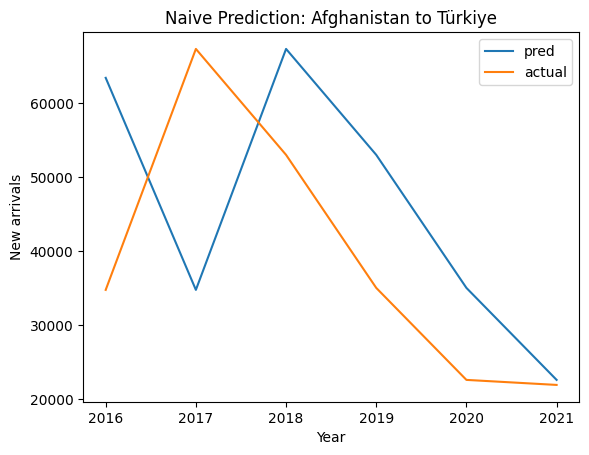

In [255]:
ax = data[filter_multi(data, 'Id',['AFGTUR']) & filter_multi_date(data, 'year','2015','>=')].groupby('Id').newarrival.apply(lambda x: rolling_prediction(x, 1,1)).reset_index().drop(['Id','level_1'],axis=1)
ax.index = pd.Series([*range(2016, 2022)]).astype(str)
ax = ax.plot.line(title='Naive Prediction: Afghanistan to Türkiye')
ax.set_xlabel("Year")
ax.set_ylabel("New arrivals")

In [243]:
# serial
naive_metrics = data[filter_multi_date(data, 'year','2015','>=')].newarrival.groupby(level='Id').apply(lambda x:rolling_rmse(x, 1, 3)).groupby('horizon').mean()
naive_metrics.to_markdown()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>naive</th>\n    </tr>\n    <tr>\n      <th>horizon</th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>1</th>\n      <td>92.605566</td>\n    </tr>\n    <tr>\n      <th>2</th>\n      <td>119.006325</td>\n    </tr>\n    <tr>\n      <th>3</th>\n      <td>121.472043</td>\n    </tr>\n  </tbody>\n</table>'

#### RF Baseline

In [97]:
def multi_shift(df, shift_range, columns):
    shifted_data = []
    for shift_value in range(shift_range.start, shift_range.stop):
        shifted = df[columns].shift(shift_value)
        shifted_data.append(shifted)
    shifted_df = pd.concat(shifted_data, axis=1, keys=[f'Shift_{shift_value}' for shift_value in range(shift_range.start, shift_range.stop)])
    shifted_df.columns = [' '.join(col).strip() for col in shifted_df.columns.values]
    return pd.concat([df, shifted_df],axis=1).dropna()

In [101]:
lagged_data = data.groupby('Id').apply(lambda x: multi_shift(x, range(1,5), ['newarrival','dead_o'])).reset_index(level=2,drop=True)

h1 = lagged_data.groupby('Id').newarrival.shift(-1)

pop_o    CPI_o  GDP_PP_o  GDP_PPP_o  island_o    area_o   
Id     year                                                                   
ABWAFG 2004-01-01   0.095    2.774  39054.94      0.005         1     193.0  \
       2005-01-01   0.098    3.787  37910.69      0.005         1     193.0   
       2006-01-01   0.099    2.510  37655.07      0.005         1     193.0   
       2007-01-01   0.100    9.920  38530.06      0.005         1     193.0   
       2008-01-01   0.101   -1.859  38939.16      0.005         1     193.0   
...                   ...      ...       ...        ...       ...       ...   
ZWEZMB 2017-01-01  14.437    3.430   2311.53      0.027         0  390759.0   
       2018-01-01  14.642   42.074   2387.04      0.028         0  390759.0   
       2019-01-01  14.905  521.150   2200.74      0.025         0  390759.0   
       2020-01-01  15.189  348.586   2048.27      0.025         0  390759.0   
       2021-01-01  15.492   60.737   2151.97      0.025         0  390759.0   

                   landlocked_o  PR_o  CL_o  typeOfViolence_o  ...  smctry   
Id     year                                                    ...           
ABWAFG 2004-01-01             0     3     3                 0  ...       0  \
       2005-01-01             0     6     5                 0  ...       0   
       2006-01-01             0     3     3                 0  ...       0   
       2007-01-01             0     1     1                 0  ...       0   
       2008-01-01             0     2     3                 0  ...       0   
...                         ...   ...   ...               ...  ...     ...   
ZWEZMB 2017-01-01             1     6     5                 0  ...       0   
       2018-01-01             1     5     5                 3  ...       0   
       2019-01-01             1     5     5                 3  ...       0   
       2020-01-01             1     6     5                 3  ...       0   
       2021-01-01             1     6     5                 3  ...       0   

                           dist  Shift_1 newarrival  Shift_1 dead_o   
Id     year                                                           
ABWAFG 2004-01-01  13257.814453                 0.0             0.0  \
       2005-01-01  13257.814453                 0.0             0.0   
       2006-01-01  13257.814453                 0.0             0.0   
       2007-01-01  13257.814453                 0.0             0.0   
       2008-01-01  13257.814453                 0.0             0.0   
...                         ...                 ...             ...   
ZWEZMB 2017-01-01    396.804077                 2.0             0.0   
       2018-01-01    396.804077                 0.0             0.0   
       2019-01-01    396.804077                 2.0             0.0   
       2020-01-01    396.804077                 0.0             0.0   
       2021-01-01    396.804077                 1.0             0.0   

                   Shift_2 newarrival  Shift_2 dead_o  Shift_3 newarrival   
Id     year                                                                 
ABWAFG 2004-01-01                 0.0             0.0                 0.0  \
       2005-01-01                 0.0             0.0                 0.0   
       2006-01-01                 0.0             0.0                 0.0   
       2007-01-01                 0.0             0.0                 0.0   
       2008-01-01                 0.0             0.0                 0.0   
...                               ...             ...                 ...   
ZWEZMB 2017-01-01                 2.0             0.0                 0.0   
       2018-01-01                 2.0             0.0                 2.0   
       2019-01-01                 0.0             0.0                 2.0   
       2020-01-01                 2.0             0.0                 0.0   
       2021-01-01                 0.0             0.0                 2.0   

                   Shift_3 dead_o  Shift_4 newarriv

In [240]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

X_train = lagged_data[filter_multi_date(lagged_data, 'year',end_train,'<=')]
y_train = h1[filter_multi_date(h1, 'year',end_train,'<=')]

rf = RandomForestRegressor(n_jobs = -1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [353]:
X_test = lagged_data[filter_multi_date(lagged_data, 'year',end_train,'>')]
X_test = X_test[filter_multi_date(X_test, 'year','2021','<')]
y_test = h1[filter_multi_date(h1,'year',end_train,'>')].dropna()

In [ ]:
from sklearn.metrics import mean_squared_error
pred_df = pd.concat([X_test.reset_index(), pd.Series(rf.predict(X_test), name='pred'), pd.Series(y_test,name='actual').reset_index(drop=True)], axis=1)
pred_df['abs_error'] = pred_df.apply(lambda x: np.abs(x.actual- x.pred), axis=1)

Text(0, 0.5, 'Actual Count')

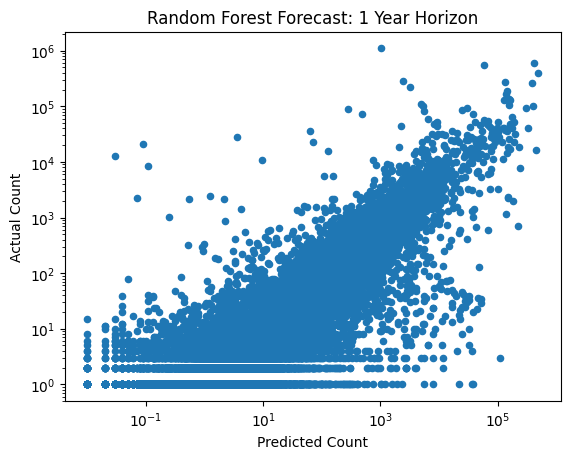

In [165]:
ax = pred_df.plot.scatter(x='pred',y='actual', logx=True,logy=True,title='Random Forest Forecast: 1 Year Horizon')
ax.set_xlabel("Predicted Newarrival Count")
ax.set_ylabel("Actual Newarrival Count")

Text(0, 0.5, 'Actual Newarrival Count')

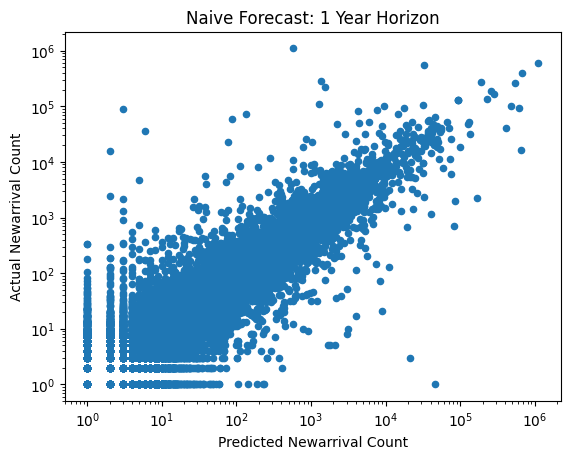

In [166]:
ax = pred_df.plot.scatter(x='newarrival',y='actual', logx=True,logy=True,title='Naive Forecast: 1 Year Horizon')
ax.set_xlabel("Predicted Newarrival Count")
ax.set_ylabel("Actual Newarrival Count")

Text(0, 0.5, 'Root Mean Squared Error')

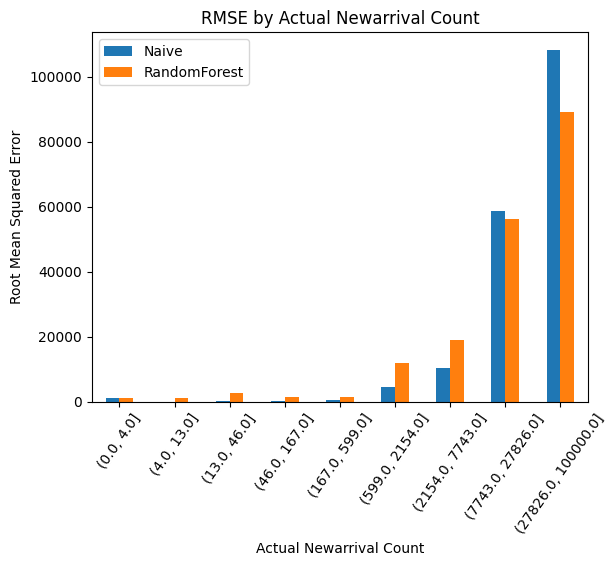

In [238]:
logspace = np.round(np.logspace(np.log10(1),np.log10(100000.0), 10), 0)
logspace[0] = 0
pred_df['bins']  = pd.cut(pred_df.actual+1, logspace )

naive_rmse = pred_df.groupby('bins').apply(lambda x: mean_squared_error(x.actual, x.newarrival, squared=False))
rf_rmse = pred_df.groupby('bins').apply(lambda x: mean_squared_error(x.actual, x.pred, squared=False))

ax = pd.DataFrame({'Naive':naive_rmse, 'RandomForest':rf_rmse}).plot.bar(rot=55, title='RMSE by Actual Newarrival Count')
ax.set_xlabel("Actual Newarrival Count")
ax.set_ylabel("Root Mean Squared Error")

### Proposed Framework Model

In [271]:
import numpy as np
import pandas as pd

data_outflows = pd.read_csv('../../data/data.csv', engine='pyarrow').drop_duplicates(subset=['Id','year'])[['iso_o', 'year', 'pop_o', 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o',
       'island_o', 'area_o', 'landlocked_o', 'PR_o', 'CL_o',
       'typeOfViolence_o', 'best_est_o', 'Nyear_conflict_o', 'Nyear_log_o',
       'dead_log_o', 'Nyear_conf_o', 'dead_o', 'newarrival']]

# preprocessing
data_outflows['year'] = pd.to_datetime(data_outflows['year'], format='%Y')
data_outflows = pd.concat([data_outflows.drop('newarrival',axis=1).groupby(['iso_o', 'year']).first(),data_outflows.groupby(['iso_o', 'year']).newarrival.sum()],axis=1)

In [280]:
# create lagged dataset
lagged_outflows = data_outflows.groupby('iso_o').apply(lambda x: multi_shift(x, range(1,5), ['newarrival','dead_o'])).reset_index(level=1,drop=True)
h1_outflows = lagged_outflows.groupby('iso_o').newarrival.shift(-1)

In [281]:
# Implement random forest
X_train = lagged_outflows[filter_multi_date(lagged_outflows, 'year',end_train,'<=')]
y_train = h1_outflows[filter_multi_date(h1_outflows, 'year',end_train,'<=')]

rf_outflow = RandomForestRegressor(n_jobs = -1)
rf_outflow.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [357]:
X_test = lagged_outflows[filter_multi_date(lagged_outflows, 'year',end_train,'>')]
X_test = X_test[filter_multi_date(X_test, 'year','2021','<')]
y_test = h1_outflows[filter_multi_date(h1_outflows,'year',end_train,'>')].dropna()

In [358]:
y_pred = pd.Series(rf_outflow.predict(X_test), name='pred').to_frame()
y_pred.index = X_test.index

In [359]:
data_prop = pd.read_csv('../../data/data.csv', engine='pyarrow').drop_duplicates(subset=['Id','year'])

# preprocessing
data_prop['year'] = pd.to_datetime(data_prop['year'], format='%Y')
data_prop['prop'] = data_prop['newarrival'] / (data_prop.groupby(['iso_o','year'])['newarrival'].transform('sum')+.001)
data_prop = data_prop.pivot(values='prop',columns='iso_d', index=['year','iso_o']).fillna(value=0)

In [368]:
data_prop_test = y_pred.merge(data_prop.groupby('iso_o').shift(1), left_index=True, right_index=True, how='left')
melted = data_prop_test.drop('pred',axis=1).apply(lambda x: x*y_test, axis=0).dropna().reset_index().melt(id_vars=['iso_o','year'],var_name='iso_d',value_name='newarrival')

In [372]:
melted = melted[melted.iso_o != melted.iso_d]
melted['Id'] = melted.iso_o + melted.iso_d
melted = melted.set_index(['Id','year']).drop(['iso_o','iso_d'],axis=1)

In [380]:
outflow_pred = pred_df.merge(melted, right_index=True, left_on=['Id','year'])
rf2_rmse = outflow_pred.groupby('bins').apply(lambda x: mean_squared_error(x.actual, x.newarrival_y, squared=False))

Text(0, 0.5, 'Root Mean Squared Error')

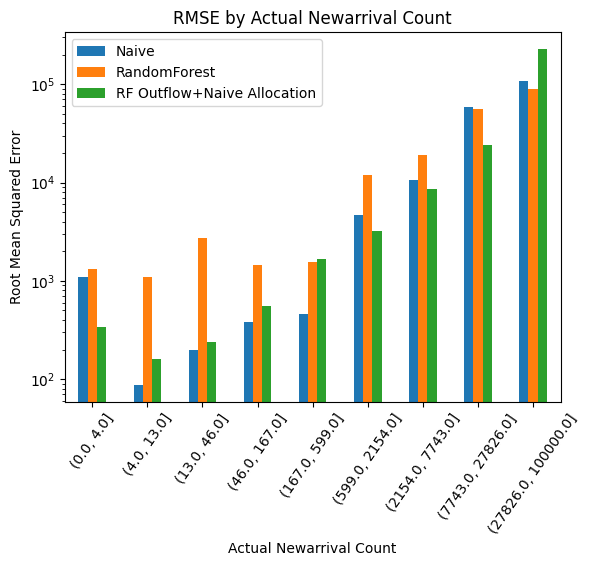

In [388]:
ax = pd.DataFrame({'Naive':naive_rmse, 'RandomForest':rf_rmse, 'RF Outflow+Naive Allocation':rf2_rmse}).plot.bar(rot=55, title='RMSE by Actual Newarrival Count', logy=True)
ax.set_xlabel("Actual Newarrival Count")
ax.set_ylabel("Root Mean Squared Error")


Text(0, 0.5, 'Root Mean Squared Error')

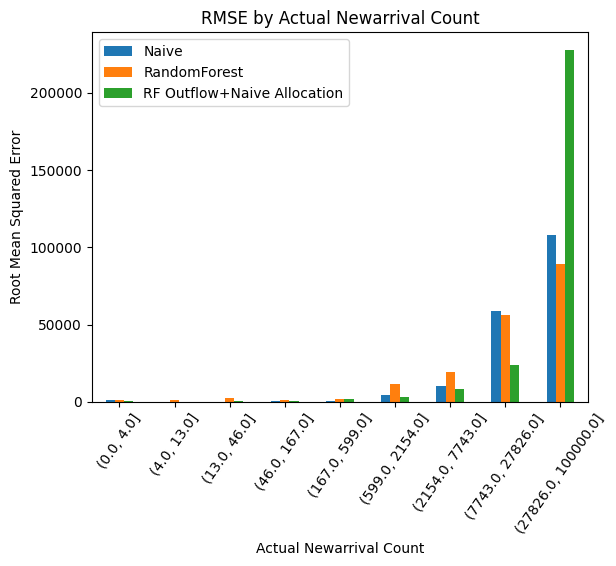

In [389]:
ax = pd.DataFrame({'Naive':naive_rmse, 'RandomForest':rf_rmse, 'RF Outflow+Naive Allocation':rf2_rmse}).plot.bar(rot=55, title='RMSE by Actual Newarrival Count', logy=False)
ax.set_xlabel("Actual Newarrival Count")
ax.set_ylabel("Root Mean Squared Error")

In [395]:
mean_squared_error(pred_df.actual[pred_df.actual<=27826], pred_df.newarrival[pred_df.actual<=27826], squared=False)

2093.3171345975284

In [396]:
mean_squared_error(pred_df.actual[pred_df.actual<=27826], outflow_pred.newarrival_y[pred_df.actual<=27826], squared=False)

926.691332493735

In [397]:
mean_squared_error(pred_df.actual[pred_df.actual<=27826], outflow_pred.pred[pred_df.actual<=27826], squared=False)

2487.778743295513